# Features comparison

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import mlflow
import mlflow.sklearn
import scipy
from scipy import stats
from tqdm.notebook import trange, tqdm

from DataHelper import *

# increase plot size
plt.rcParams["figure.figsize"] = (20,8)

sns.set_theme()

font = {'family' : 'DejaVu Sans', 'size'   : 25}

matplotlib.rc('font', **font)

In [2]:
DATA_PATH = './data'
QUOTATION = 'AAPL'
FILE_SUFFIX = '.txt'

In [3]:
predict_n = 1
price_column = 'Close'
df, feature_names = features_pipeline(f"{DATA_PATH}/{QUOTATION}{FILE_SUFFIX}", predict_n=predict_n,
    price_column=price_column, normalize_features=True)

df.head()

,Date,Open,High,Low,Close,Volume,Adjusted,Difference,PercentageDiff,Tendency,...,Next,MACD,MACD_diff,MACD_signal,BG_L_Band,BG_H_Band,BG_L_Band_Indicator,BG_H_Band_Indicator,ROC,StochOsc
34,2007-02-21,3.070714,3.196071,3.070000,3.185714,1.155314e+09,2.748159,0.016097,0.015462,higher,...,higher,-0.225796,0.233739,-0.277960,-0.992776,-0.995270,-1.0,-1.0,0.101844,-0.843479
35,2007-02-22,3.242857,3.243214,3.161786,3.196786,8.382248e+08,2.757710,0.020467,0.098997,higher,...,lower,-0.226989,0.231798,-0.278582,-0.992546,-0.995351,-1.0,-1.0,0.014759,-0.518821
36,2007-02-23,3.184286,3.226429,3.173214,3.181072,5.178936e+08,2.744154,0.015090,-0.006782,lower,...,lower,-0.228913,0.228488,-0.279518,-0.992440,-0.995407,-1.0,-1.0,-0.036116,-0.946829
37,2007-02-26,3.208571,3.214286,3.128929,3.161072,6.158488e+08,2.726901,0.025983,0.209021,lower,...,lower,-0.229920,0.228046,-0.280495,-0.992173,-0.995539,-1.0,-1.0,0.072648,-0.595277
38,2007-02-27,3.082143,3.110000,2.978929,2.997500,1.145813e+09,2.585796,0.018109,0.051914,lower,...,higher,-0.231257,0.226896,-0.281582,-0.992283,-0.995486,-1.0,-1.0,0.020674,-0.771923


In [4]:
def compute_t_test_classes(df, feature_names, classes, class_column='Next', equal_var=False):
    feature_p_vals = {}
    for feature in feature_names:
        # get the filtered series with only the feature, filtered by the target class
        a = df[df[class_column] == classes[0]][feature]
        b = df[df[class_column] == classes[1]][feature]


        t_stat, p_computed = stats.ttest_ind(a, b, equal_var = equal_var)
        feature_p_vals[feature] = p_computed
            
    # return the dictionary sorted by p_value (ASC)
    plt.show()
    return {k: v for k, v in sorted(feature_p_vals.items(), key=lambda item: item[1])}

In [5]:
classes = list(df['Next'].value_counts().to_dict().keys())
test_feature_names = feature_names + ['Volume']
test_feature_names = [feature for feature in test_feature_names if feature not in ['Next','Tendency']] 

feature_p_vals = compute_t_test_classes(df, test_feature_names, classes)
print(feature_p_vals)

{'MACD_diff': 2.4925146446678277e-05, 'MACD_signal': 0.0008723034564244542, 'RSI(14)': 0.012991475833886516, 'MACD': 0.04501172458118558, 'StochOsc': 0.22101452738763253, 'BG_L_Band': 0.2670511317812806, 'MA(10)': 0.31244300769595984, 'BG_H_Band': 0.32540285150253934, 'Volume_diff': 0.4726173444380658, 'BG_H_Band_Indicator': 0.4776802825541794, 'Volume': 0.5622170863473047, 'BG_L_Band_Indicator': 0.5956084651794242, 'MA(20) - MA(10)': 0.6108953400064943, 'GAP': 0.7432412922223985, 'PercentageDiff': 0.7498024004973125, 'RSI_Diff': 0.8232965003332846, 'ROC': 0.926187865211678, 'Difference': 0.9619342558522586}


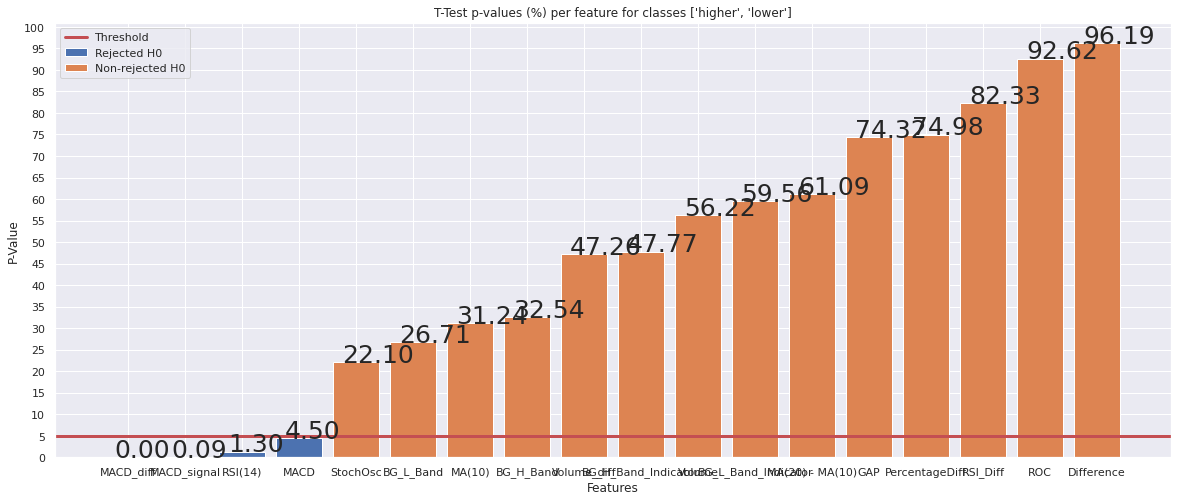

In [6]:
P_THRESH = 0.05


lowers = [(label, val) for label, val in feature_p_vals.items() if val <= P_THRESH]
highers = [(label, val) for label, val in feature_p_vals.items() if val > P_THRESH]


plt.bar([t[0] for t in lowers], [t[1]*100 for t in lowers], label="Rejected H0") 
plt.bar([t[0] for t in highers], [t[1]*100 for t in highers], label="Non-rejected H0")


x_locs, _ = plt.xticks()
for i, value in enumerate([x*100 for x in feature_p_vals.values()]):
    plt.text(x_locs[i] - 0.25, value + 0.01, f"{value:.2f}")
    
plt.axhline(y = P_THRESH * 100, color = 'r', linestyle = '-', linewidth=3.0, label="Threshold")
plt.yticks(np.arange(0, 101, step=5))
plt.title(f"T-Test p-values (%) per feature for classes {classes}")
plt.legend(loc='best')
plt.xlabel('Features')
plt.ylabel('P-Value')
plt.show()

In [7]:
df_dict = import_folder(DATA_PATH, files_pattern="*.txt", normalize_features=True)

higher_features_dict = {k:0 for k,v in feature_p_vals.items()}
lower_features_dict = {k:0 for k,v in feature_p_vals.items()}

# for each dataset given count the times where the features was higher or lower than the threshold
for (df, label) in df_dict:
    df = df[0]
    feature_p_vals = compute_t_test_classes(df, test_feature_names, classes)
    for k,v in feature_p_vals.items():
        if v > P_THRESH:
            higher_features_dict[k] += 1
        else:
            lower_features_dict[k] += 1

In [8]:
df = pd.DataFrame(list(lower_features_dict.items()), columns=['Feature','Lower'])
# add the sum for the plot
df['Sum'] = pd.Series(sum(val) for val in zip(higher_features_dict.values(), lower_features_dict.values()))
df = df.sort_values(by='Lower', ascending=False)
df

,Feature,Lower,Sum
0,MACD_diff,6,10
1,MACD_signal,6,10
7,BG_H_Band,4,10
5,BG_L_Band,4,10
6,MA(10),4,10
3,MACD,3,10
10,Volume,2,10
9,BG_H_Band_Indicator,2,10
2,RSI(14),1,10
13,GAP,1,10


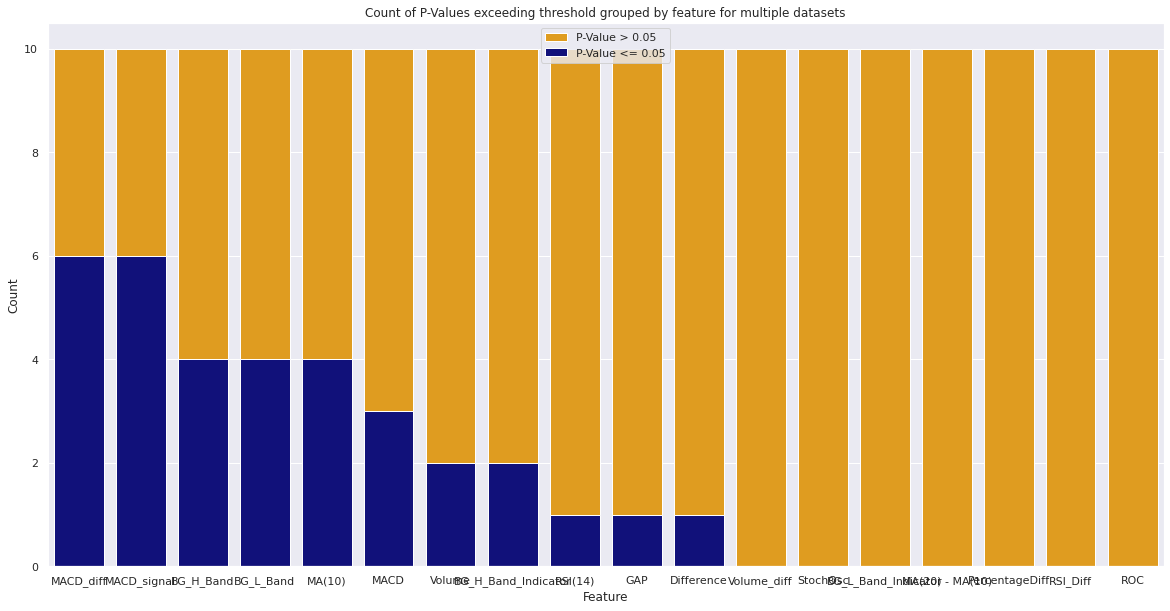

In [9]:
plt.figure(figsize=(20,10))

bar_upper = sns.barplot(x='Feature', y='Sum',  data=df, color='orange', label=f"P-Value > {P_THRESH}")
bar_lower = sns.barplot(x='Feature', y='Lower', estimator=sum, data=df, color='darkblue', label=f"P-Value <= {P_THRESH}")
plt.title("Count of P-Values exceeding threshold grouped by feature for multiple datasets")
plt.legend(loc='best')
plt.ylabel('Count')
plt.show()